In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [5]:
#Step 1 Load Data
f = open('sp500.csv', 'r').read()
data = f.split('\n')

seq_len=50 
normalise_window=True
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

#every element in result is a sequence_length list
#print(result[1])

if normalise_window:
    result = normalise_windows(result)
    
result = np.array(result)
print(result.shape[0],result.shape[1])

row = round(0.9 * result.shape[0])
print(row)

train = result[:int(row), :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]

x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]
print(x_train[:2])

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train[:2])

4121 51
3709
[[ 0.         -0.00645053 -0.01055618 -0.03584306 -0.03100716 -0.07734483
  -0.07787528 -0.13932056 -0.09851846 -0.13832104 -0.0984339  -0.09369016
  -0.07394654 -0.08296496 -0.08209617 -0.12302891 -0.13619135 -0.13596846
  -0.10634524 -0.09462051 -0.10871322 -0.09523553 -0.06964878 -0.06746523
  -0.06287531 -0.07400032 -0.09741139 -0.1041233  -0.0784596  -0.08823915
  -0.11258817 -0.10640671 -0.09825709 -0.08610177 -0.07039453 -0.06508955
  -0.0742541  -0.07579176 -0.10295465 -0.13155526 -0.12627337 -0.10588396
  -0.0963273  -0.11502532 -0.10784443 -0.13012524 -0.15487407 -0.1358685
  -0.12043025 -0.1043309 ]
 [ 0.         -0.00106586  0.01040381  0.01316754  0.00741382  0.01410133
   0.01537468  0.02735384  0.02686334  0.0309003   0.03380555  0.03193796
   0.03368292  0.04650147  0.04665242  0.04880302  0.04555823  0.05851828
   0.05988604  0.06239497  0.06766774  0.05817873  0.0632439   0.05757505
   0.06634719  0.06779037  0.07512866  0.07412889  0.0824765   0.07900534

In [50]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\DELL\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\DELL\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=200, input_shape=(None, 1))`


compilation time :  0.02905130386352539


C:\Users\DELL\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [46]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=3,
    validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/3
3523/3523 [==============================] - 23s - loss: 0.0034 - val_loss: 0.0021
Epoch 2/3
3523/3523 [==============================] - 21s - loss: 0.0013 - val_loss: 0.0012
Epoch 3/3
3523/3523 [==============================] - 21s - loss: 9.7810e-04 - val_loss: 0.0011


In [47]:
len(x_test)

412

In [48]:
correct = 0
prediction_seqs = []
for i in range(len(x_test)-1):
    curr_frame = x_test[i]
    predicted = []
    predict = model.predict(curr_frame[newaxis,:,:])[0,0]
    predicted.append(predict)
    difference_true = y_test[i+1] - y_test[i]
    difference_predict = predict - y_test[i]
    if (difference_true>0 and difference_predict >0) or (difference_true<0 and difference_predict<0):
        correct += 1
    prediction_seqs.append(predicted)
predictions = prediction_seqs

print(float(correct/len(x_test)))

0.5097087378640777


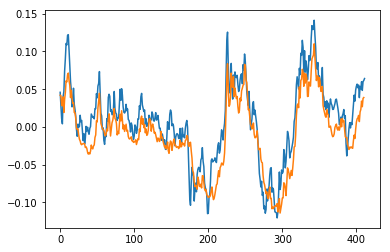

In [49]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
ax.plot(predictions, label='Prediction')
plt.show()

In [ ]:
#Step 4 - Plot the predictions!
window_size = 50
prediction_len = 5
#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
prediction_seqs = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i*prediction_len]
    predicted = []
    for j in range(1):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
predictions = prediction_seqs

correct = 0
for i in range(int(len(x_test)/prediction_len)):
    last_frame = i * prediction_len
    difference_true = y_test[last_frame+1] - y_test[last_frame]
    difference_predict = predictions[i][0] - y_test[last_frame]
    if (difference_true>0 and difference_predict >0) or (difference_true<0 and difference_predict<0):
        correct += 1
print(float(correct/len(predictions)))

yo


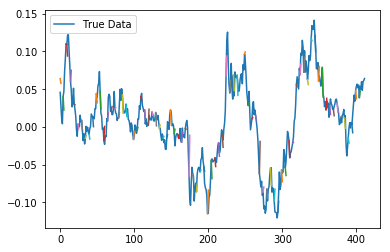

In [99]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
print('yo')
#Pad the list of predictions to shift it in the graph to it's correct start
for i, data in enumerate(predictions):
    padding = [None for p in range(i * prediction_len-1)]
    plt.plot(padding + [y_test[i*prediction_len-1]] + data, label='')
    plt.legend()
plt.show()

In [88]:
test = [1,2,3,4,5,6,7,8,9]
a = [None for x in range(9)]
print(a)

[None, None, None, None, None, None, None, None, None]
